In [1]:
"""Volume 2: Non-negative Matrix Factorization."""

import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import os
from imageio import imread
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error as mse

In [2]:
#Problems 1-2
class NMFRecommender:

    def __init__(self, random_state=15, rank=3, maxiter=200, tol=1e-3):
        """The parameter values for the algorithm"""

        self.random_state = random_state
        self.maxiter = maxiter
        self.tol = tol
        self.rank = rank
        self.W = None
        self.H = None        
        
    
    def initialize_matrices(self, m, n):
        """randomly initialize the W and H matrices,"""
        random_seed = np.random.seed(self.random_state)
        
        self.W = np.random.random((m, self.rank))
        self.H = np.random.random((self.rank, n))
        
        return self.W, self.H

      
    def fit(self, V):
        """Fits W and H weight matrices using CVXPY"""
        
        # initialize previous step matrices
        self.initialize_matrices(V.shape[0], V.shape[1])
                            
        oldW = np.zeros_like(self.W)
        oldH = np.zeros_like(self.H)
        
        
        # set looping controls
        optW = True
        count = 0
        
        # while we haven't reache the tolerance or taken too many steps
        while count < self.maxiter:
                
            # update the previous step and initialize the optimization problem
            W = cp.Variable(self.W.shape, nonneg=True)
            objW = cp.Minimize(cp.norm(V - W @ self.H, p='fro'))
            # solve the optimization problem
            probW = cp.Problem(objW)
            probW.solve()
            self.W = W.value
            
            H = cp.Variable(self.H.shape, nonneg=True)
            objH = cp.Minimize(cp.norm(V - self.W @ H, p='fro'))
            # solve the optimization problem
            probH = cp.Problem(objH)
            probH.solve()
            self.H = H.value
                
            if np.linalg.norm(V - self.W @ self.H, ord="fro") < self.tol:
                break
            count += 1
        
        return self.W, self.H


    def reconstruct(self):
        """Reconstruct V matrix for comparison against the original V"""
        # Reconstruct V matrix for comparison against the original V
        return self.W @ self.H

In [3]:
def prob3():
    """Run NMF recommender on the grocery store example"""
    V = np.array(
        [
            [0, 1, 0, 1, 2, 2],
            [2, 3, 1, 1 ,2, 2],
            [1, 1, 1, 0, 1, 1],
            [0, 2, 3, 4, 1, 1],
            [0, 0, 0, 0, 1, 0]
        ]
    )
    
    rec = NMFRecommender(rank=2)
    rec.initialize_matrices(V.shape[0], V.shape[1])
    rec.fit(V)
    
    return rec.W, rec.H, np.sum(rec.H[0,:] < rec.H[1,:])

In [4]:
prob3()

(array([[4.32480191e-01, 1.55954416e+00],
        [7.28906415e-01, 2.67373283e+00],
        [2.59466489e-01, 1.23238130e+00],
        [2.77259088e+00, 7.64369539e-08],
        [2.08546906e-09, 3.68889128e-01]]),
 array([[4.28503903e-08, 7.25973906e-01, 1.07543057e+00, 1.44598707e+00,
         3.52852850e-01, 3.65398494e-01],
        [5.85611950e-01, 7.72213331e-01, 6.59496409e-02, 5.89472429e-09,
         8.03616848e-01, 7.67499335e-01]]),
 4)

In [5]:
#get data
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory.
    Flatten and convert each image to grayscale.

    Parameters:
        path (str): The directory containing the dataset of images.

    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)

def show(image, plt_show=False, subtitle="", m=200, n=180):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.

    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
        plt_show (bool): if True, call plt.show() at the end
    """
    #scale image
    image = image / 255
    #reshape image
    image = np.reshape(image,(m,n))
    #show image
    plt.imshow(image,cmap = "gray")
    plt.title(subtitle)
    plt.axis('off')
    
    if plt_show:
        plt.show()


In [6]:
def prob4():
    """
        Gridsearch over rank, alpha and l1_ratio values to reconstruct 
        image using NMF. Plot all reconstructed images.
    """
    # initialize grid search
    n_components = [75]
    alpha = [0, .2, .5]
    l1_ratio = [0, 1e-5, 1]
    combinations = np.array(np.meshgrid(n_components, alpha, l1_ratio)).T.reshape(-1, 3)
    print("combinations")
    print(combinations)
    
    # get all faces and display the third face
    faces = get_faces()
    third = faces[:,2]
    show(third, True, "Original")

    # initialize search variables
    best_norm = 0
    best_combo = []
    
    for i, combo in enumerate(combinations):
        # compute the reconstruction
        model = NMF(n_components=int(combo[0]), alpha=combo[1], l1_ratio=combo[2])
        W = model.fit_transform(faces)
        H = model.components_
        
        # update search varaibles
        norm = np.linalg.norm(faces[:,2] - W@H[:,2])
        if best_norm == 0 or norm < best_norm:
            best_norm = norm
            best_combo = combo
        
        # show reconstructed face
        title = f"n: {combo[0]}, alpha: {combo[1]}, ratio: {combo[2]}, norm: {np.round(norm, 2)})"
        print(title)
        show((W@H[:,2]), True)

    print(f"The best combination is {best_combo} with a norm of {np.round(best_norm, 2)}")
    return best_combo

combinations
[[7.5e+01 0.0e+00 0.0e+00]
 [7.5e+01 2.0e-01 0.0e+00]
 [7.5e+01 5.0e-01 0.0e+00]
 [7.5e+01 0.0e+00 1.0e-05]
 [7.5e+01 2.0e-01 1.0e-05]
 [7.5e+01 5.0e-01 1.0e-05]
 [7.5e+01 0.0e+00 1.0e+00]
 [7.5e+01 2.0e-01 1.0e+00]
 [7.5e+01 5.0e-01 1.0e+00]]


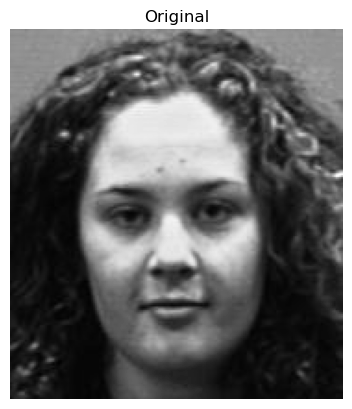

n: 75.0, alpha: 0.0, ratio: 0.0, norm: 3247.889892578125)


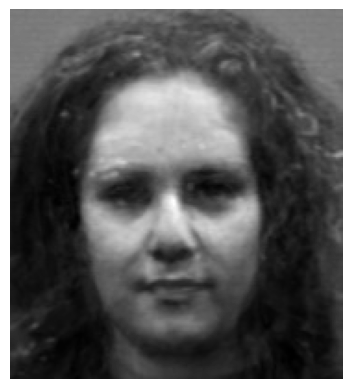

n: 75.0, alpha: 0.2, ratio: 0.0, norm: 3092.5400390625)


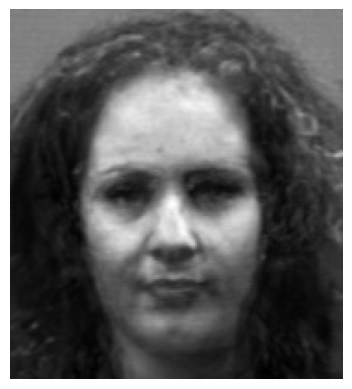

n: 75.0, alpha: 0.5, ratio: 0.0, norm: 3509.81005859375)


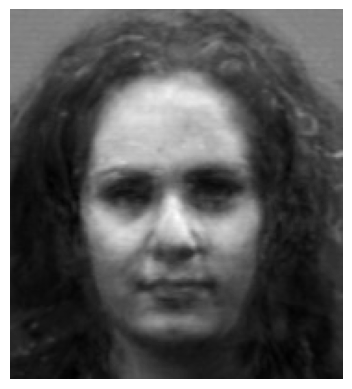

n: 75.0, alpha: 0.0, ratio: 1e-05, norm: 3263.510009765625)


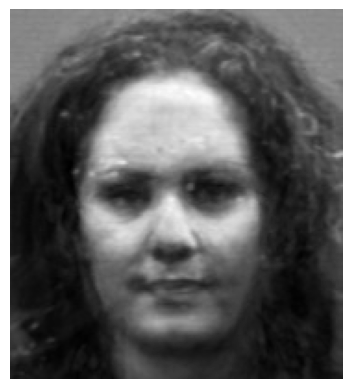

n: 75.0, alpha: 0.2, ratio: 1e-05, norm: 3117.330078125)


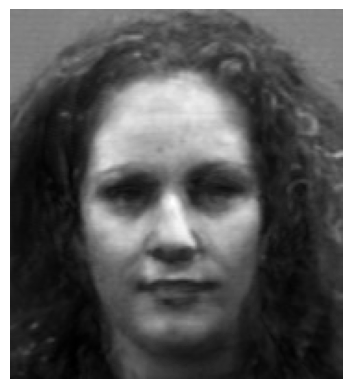

n: 75.0, alpha: 0.5, ratio: 1e-05, norm: 3466.14990234375)


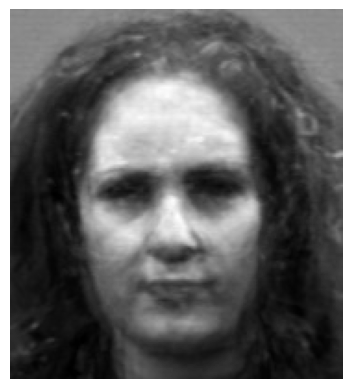

n: 75.0, alpha: 0.0, ratio: 1.0, norm: 3440.510009765625)


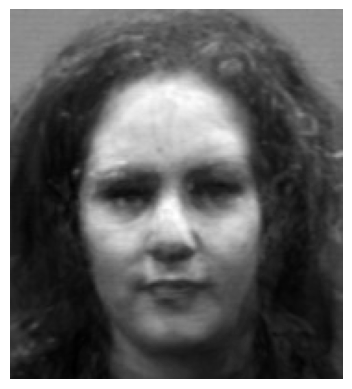

n: 75.0, alpha: 0.2, ratio: 1.0, norm: 3138.860107421875)


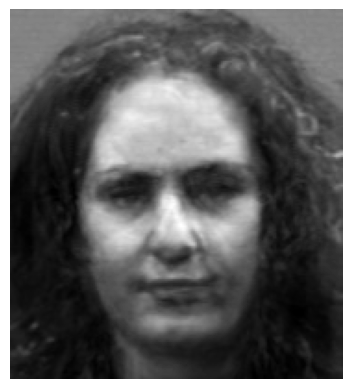

n: 75.0, alpha: 0.5, ratio: 1.0, norm: 3049.110107421875)


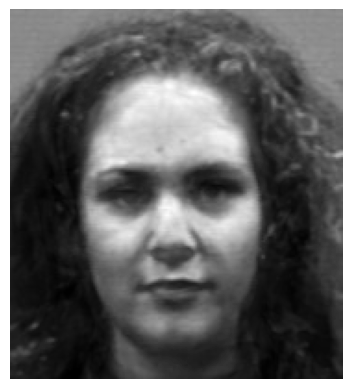

The best combination is [75.   0.5  1. ] with a norm of 3049.110107421875


In [7]:
results = prob4()

In [8]:
def prob5():
    '''
        find the 10 basis faces with the largest coefficients 
        corresponding to the the second and twelfth face in the dataset. 
        Plot these basis faces along with the original image using 
        subplots
    '''
    # get all faces and display the selected faces
    faces = get_faces()
    second = faces.T[1]
    twelth = faces.T[11]
        
    # set nmf variables based on results from problem four
    n_components = results[0]
    alpha = results[1]
    l1_ratio = results[2]
    
    # run nmf to get W and H
    model = NMF(n_components=int(n_components), alpha=alpha, l1_ratio=l1_ratio)
    W = model.fit_transform(faces)
    H = model.components_
    
    # get the top ten basis faces
    second_basis = np.argsort(H[:,1])[-10:]
    twelth_basis = np.argsort(H[:,11])[-10:]

    # plot the original second with each of its basis faces
    show(second, True, "Second Face")
    for i in second_basis:
        show(W[:,i], True)
        
    # plot the original twelth with each of its basis faces
    show(twelth, True, "Twelth Face")
    for j in twelth_basis:
        show(W[:,j], True)
        
    plt.show()

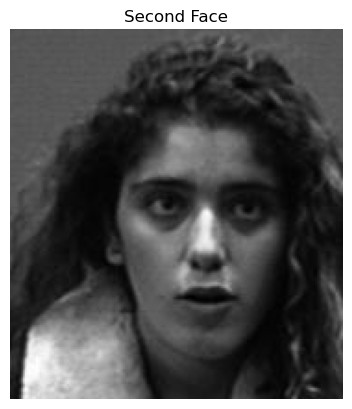

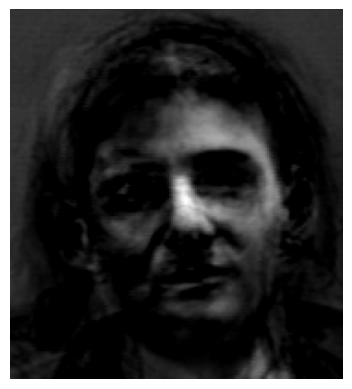

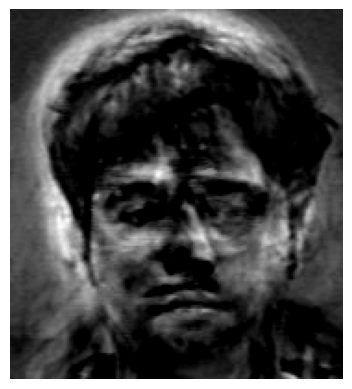

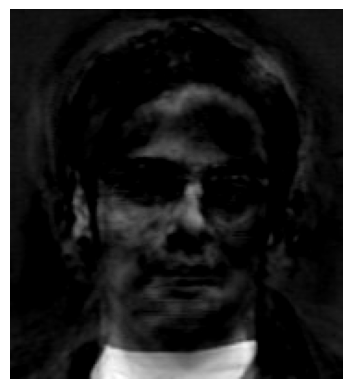

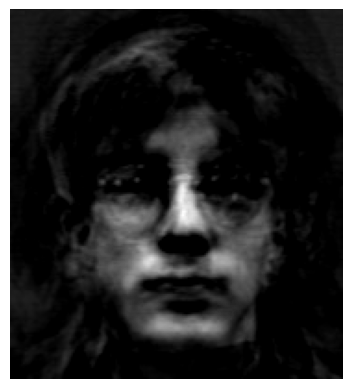

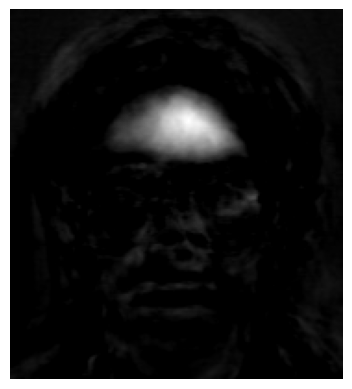

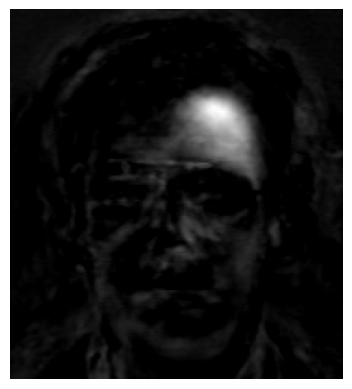

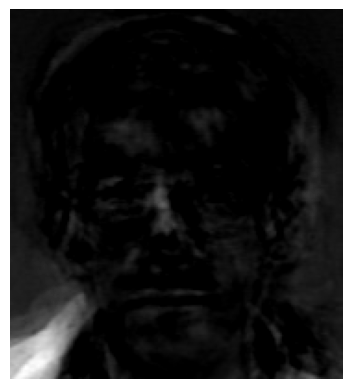

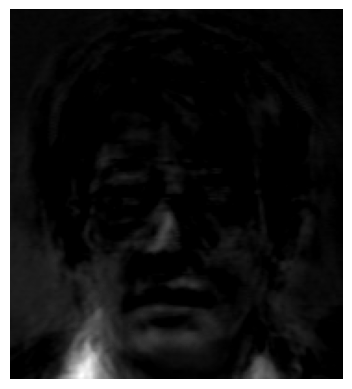

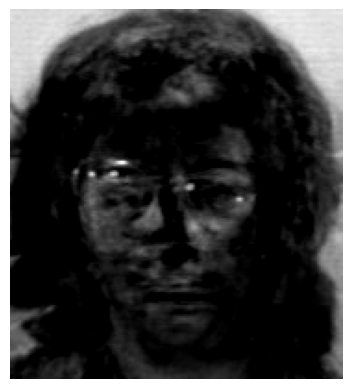

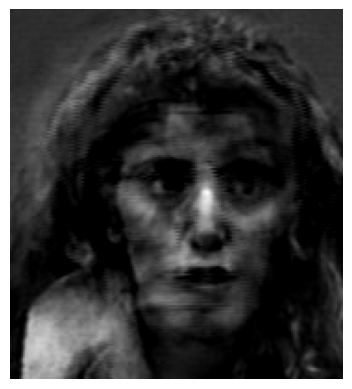

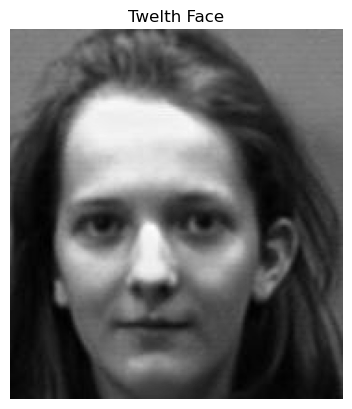

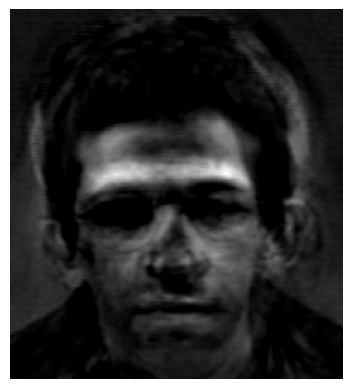

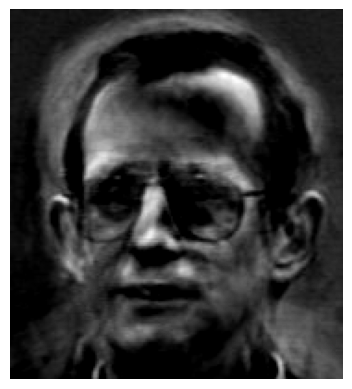

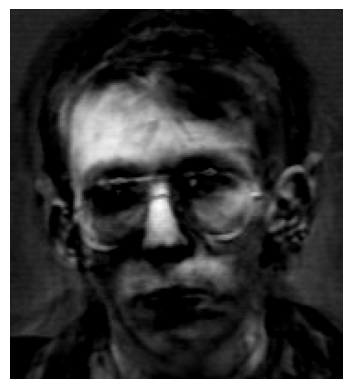

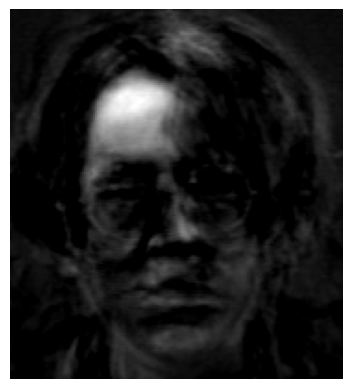

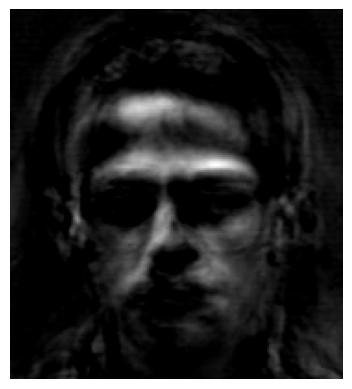

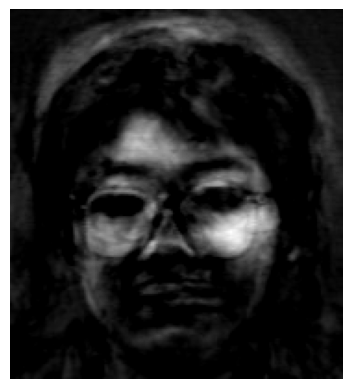

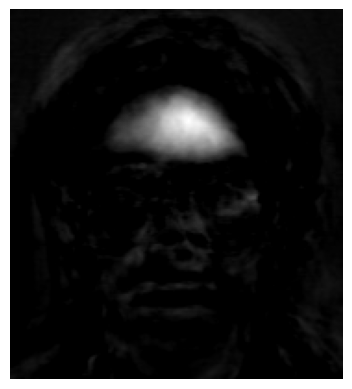

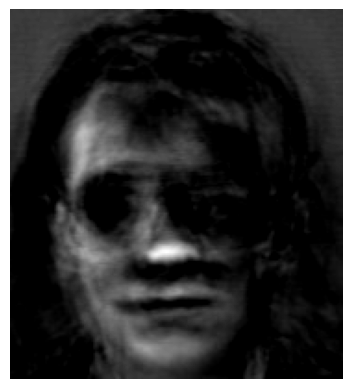

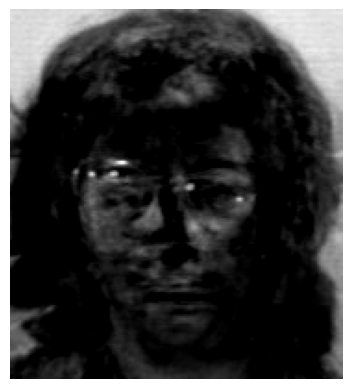

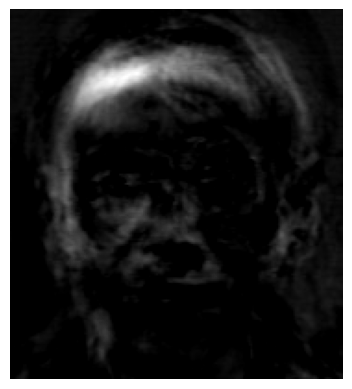

In [9]:
prob5()

Each of the basis faces with the highest coefficients highlights a different part of the original face.